In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from seqprop.visualization import *
from seqprop.generator import *
from seqprop.predictor import *
from seqprop.optimizer import *

from definitions.mpradragonn_deep_factorized_model import load_saved_predictor

import warnings
warnings.simplefilter("ignore")

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:
#Download MPRA-DragoNN models
#!wget https://github.com/kundajelab/MPRA-DragoNN/raw/master/kipoi/ConvModel/pretrained.hdf5
#!wget https://github.com/kundajelab/MPRA-DragoNN/raw/master/kipoi/DeepFactorizedModel/pretrained.hdf5


In [3]:
import random
import math

def vectorizeSequence(seq):
    # the order of the letters is not arbitrary.
    # Flip the matrix up-down and left-right for reverse compliment
    ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    return np.array([ltrdict[x] for x in seq])

def ret_rand_nuc():
    x = random.randint(0,3)
    if x == 0:
        return [1,0,0,0] # A
    if x == 1:
        return [0,1,0,0] # C
    if x == 2:
        return [0,0,1,0] # G
    if x == 3:
        return [0,0,0,1] # T
    
def vector_to_nuc(arr, seq_len=50):
    seq = ''
    for i in range(seq_len):
        if arr[i,0] == 1:
            seq = seq + 'A'
        if arr[i,1] == 1:
            seq = seq + 'C'
        if arr[i,2] == 1:
            seq = seq + 'G'
        if arr[i,3] == 1:
            seq = seq + 'T'
    return seq

def make_random_sequences(nbr_sequences, length, constant='', no_uaug=False, no_stop=False):
    # Make randomize sequences, allowing for the inclusion / exclusion of uATGs / stop codons
    seqs = []
    nucs = {0:'A', 1:'T', 2:'C', 3:'G'}
    i = 0
    while i < nbr_sequences:
        new_seq = ''
        for n in range(length - len(constant)):
            new_seq = new_seq + nucs[random.randint(0,3)]
        
        new_seq = new_seq + constant
        seqs.append(new_seq)
        i+=1
        
    return seqs

def simple_mutate(seq, nbr_bases=1, prob=1):
    if nbr_bases > 1 and prob > random.random():
        nbr_bases = nbr_bases
    else:
        nbr_bases = 1
    for i in range(nbr_bases):
        pos = random.randint(0, len(seq)-1)
        seq[pos] = ret_rand_nuc()
    return seq

def selection(seq, model, target_output_ix, scaler, nbr_bases_to_mutate=1, multi_mutate_prob=1, seq_len=50):
    seqs = np.empty([2, seq_len, 4])
    seqs[0] = seq.copy()
    seqs[1] = simple_mutate(seq.copy(), nbr_bases=nbr_bases_to_mutate, prob=multi_mutate_prob)
    
    scores = model.predict(seqs)[:, target_output_ix].reshape(-1)
    if scaler is not None :
        scores = scaler.inverse_transform(scores)
    if scores[1] > scores[0]:
        return seqs[1]
    else:
        return seqs[0]

def evolve(model, target_output_ix, scaler, seq_length=50, iterations=200, nbr_sequences=10) :
    # Dictionary where new sequences are saved
    evolved_seqs = {}
    # Number of bases to mutate if the probability to 'multi-mutate' is exceeded
    nbr_bases_to_mutate = 2
    # Probability to change multiple bases in an iteration
    prob_of_multi_mutation = 0.5
    # If using the original evolution model, set seq_len to 54. That model was
    # trained on UTRs that included the first for basees of the CDS (ATGG).
    seq_len = seq_length
    
    rand_seqs = make_random_sequences(nbr_sequences, seq_len)
    e_seqs = np.empty([len(rand_seqs), seq_len, 4])

    i = 0
    for seq in rand_seqs:
        e_seqs[i]=vectorizeSequence(seq.lower())
        i += 1

    for x in range(nbr_sequences):
        evolved_seqs[x] = np.empty((iterations+1,2), dtype=object)
    
    for x in range(nbr_sequences):
        evolved_seqs[x][0, 0] = vector_to_nuc(e_seqs[x])
        evolved_seqs[x][0, 1] = model.predict(e_seqs)[:, target_output_ix].reshape(-1)[x]
    

    for gen in range(0, iterations):
        for i in range(len(e_seqs)):
            # Evolve to highest score
            e_seqs[i] = selection(seq=e_seqs[i], model=model, target_output_ix=target_output_ix, scaler=scaler, nbr_bases_to_mutate=nbr_bases_to_mutate, multi_mutate_prob=prob_of_multi_mutation, seq_len=seq_len)

        for x in range(nbr_sequences):
            evolved_seqs[x][gen+1, 0] = vector_to_nuc(e_seqs[x])
            evolved_seqs[x][gen+1, 1] = model.predict(e_seqs)[:, target_output_ix].reshape(-1)[x]

        if gen % 100 == 0:
            print(gen)

    if scaler is not None :
        for x in range(nbr_sequences):
            evolved_seqs[x][:,1] = scaler.inverse_transform(evolved_seqs[x][:, 1])
    
    return evolved_seqs


In [4]:

def get_punish_margin_conv_activity(activity_margin=1.) :
    
    def _penalty(conv_out) :
        
        total_conv_out = K.abs(K.sum(conv_out, axis=-2))
        
        margin_cost = K.switch(total_conv_out < K.constant(activity_margin, shape=(1,)), K.zeros_like(total_conv_out), total_conv_out - K.constant(activity_margin, shape=(1,)))
        
        return K.mean(margin_cost, -1)
    
    return _penalty

#Define target isoform loss function
def get_earthmover_loss(target_output_ixs, pwm_start=0, pwm_end=70, pwm_target_bits=1.8, pwm_entropy_weight=0.0, conv_1_penalty=0.0, conv_1_margin=1.0, conv_2_penalty=0.0, conv_2_margin=1.0, conv_3_penalty=0.0, conv_3_margin=1.0) :
    
    punish_c = 0.0
    punish_g = 0.0
    
    entropy_mse = get_margin_entropy(pwm_start=pwm_start, pwm_end=pwm_end, min_bits=pwm_target_bits)
    
    punish_c_func = get_punish_c(pwm_start=pwm_start, pwm_end=pwm_end)
    punish_g_func = get_punish_g(pwm_start=pwm_start, pwm_end=pwm_end)
    
    pred_mask = np.zeros((1, 1, 12))
    pred_mask[0, 0, target_output_ixs] = 1.
    pred_mask = K.constant(pred_mask, dtype=tf.float32)
    
    n_masked = len(target_output_ixs)

    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, pred_score = predictor_outputs

        #Specify costs
        #fitness_loss = -1.0 * K.mean(pred_score[..., 0], axis=0)
        fitness_loss = -1.0 * K.sum(pred_score * pred_mask, axis=(0, -1)) / (n_masked * K.cast(K.shape(pred_score)[0], tf.float32))
        
        seq_loss = 0.0
        seq_loss += punish_c * K.mean(punish_c_func(sampled_pwm), axis=0)
        seq_loss += punish_g * K.mean(punish_g_func(sampled_pwm), axis=0)
        
        entropy_loss = pwm_entropy_weight * entropy_mse(pwm)
        
        #Compute total loss
        total_loss = fitness_loss + seq_loss + entropy_loss

        return K.reshape(K.sum(total_loss, axis=0), (1,))
    
    def val_loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, pred_score = predictor_outputs

        #Specify costs
        #fitness_loss = -1.0 * K.mean(pred_score[..., 0], axis=0)
        fitness_loss = -1.0 * K.sum(pred_score * pred_mask, axis=(0, -1)) / (n_masked * K.cast(K.shape(pred_score)[0], tf.float32))
        
        seq_loss = 0.0
        seq_loss += punish_c * K.mean(punish_c_func(sampled_pwm), axis=0)
        seq_loss += punish_g * K.mean(punish_g_func(sampled_pwm), axis=0)
        
        entropy_loss = pwm_entropy_weight * entropy_mse(pwm)
        
        #Compute total loss
        total_loss = fitness_loss + seq_loss + entropy_loss

        return K.reshape(K.mean(total_loss, axis=0), (1,))
    
    return loss_func, val_loss_func


def get_nop_transform() :
    
    def _transform_func(pwm) :
        
        return pwm
    
    return _transform_func

class ValidationCallback(Callback):
    def __init__(self, val_name, val_loss_model, val_steps) :
        self.val_name = val_name
        self.val_loss_model = val_loss_model
        self.val_steps = val_steps
        
        self.val_loss_history = []
        
        #Track val loss
        self.val_loss_history.append(self.val_loss_model.predict(x=None, steps=self.val_steps)[0])
    
    def on_batch_end(self, batch, logs={}) :
        #Track val loss
        val_loss_value = self.val_loss_model.predict(x=None, steps=self.val_steps)[0]
        self.val_loss_history.append(val_loss_value)


class DummyValidationCallback(Callback):
    def __init__(self, val_name) :
        self.val_name = val_name
        
        self.val_loss_history = []

class DummyFlexibleSeqPropMonitor(Callback):
    def __init__(self, measure_name='Measure') :
        self.measure_name = measure_name
        self.measure_history = [] = []
        self.entropy_history = []
        self.nt_swap_history = []
        self.prev_optimized_pwm = None

        self.n_epochs = 0


def _tmp_load_model(model_path) : 
    saved_model = Sequential()

    # sublayer 1
    saved_model.add(Conv1D(48, 3, padding='same', activation='relu', input_shape=(145, 4), name='dragonn_conv1d_1_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_1_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_1_copy'))

    saved_model.add(Conv1D(64, 3, padding='same', activation='relu', name='dragonn_conv1d_2_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_2_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_2_copy'))

    saved_model.add(Conv1D(100, 3, padding='same', activation='relu', name='dragonn_conv1d_3_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_3_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_3_copy'))

    saved_model.add(Conv1D(150, 7, padding='same', activation='relu', name='dragonn_conv1d_4_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_4_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_4_copy'))

    saved_model.add(Conv1D(300, 7, padding='same', activation='relu', name='dragonn_conv1d_5_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_5_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_5_copy'))

    saved_model.add(MaxPooling1D(3))

    # sublayer 2
    saved_model.add(Conv1D(200, 7, padding='same', activation='relu', name='dragonn_conv1d_6_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_6_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_6_copy'))

    saved_model.add(Conv1D(200, 3, padding='same', activation='relu', name='dragonn_conv1d_7_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_7_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_7_copy'))

    saved_model.add(Conv1D(200, 3, padding='same', activation='relu', name='dragonn_conv1d_8_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_8_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_8_copy'))

    saved_model.add(MaxPooling1D(4))

    # sublayer 3
    saved_model.add(Conv1D(200, 7, padding='same', activation='relu', name='dragonn_conv1d_9_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_9_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_9_copy'))

    saved_model.add(MaxPooling1D(4))

    saved_model.add(Flatten())
    saved_model.add(Dense(100, activation='relu', name='dragonn_dense_1_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_10_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_10_copy'))
    saved_model.add(Dense(12, activation='linear', name='dragonn_dense_2_copy'))

    saved_model.compile(
        loss= "mean_squared_error",
        optimizer=keras.optimizers.SGD(lr=0.1)
    )

    saved_model.load_weights(model_path)
    
    return saved_model

#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(target_output_ixs_list, sequence_templates, loss_funcs, val_loss_funcs, transform_funcs, n_sequences=1, n_samples=1, n_valid_samples=1, eval_mode='sample', normalize_logits=False, n_epochs=10, steps_per_epoch=100) :
    
    if eval_mode == 'evolve' :
        predictor = _tmp_load_model(model_path)
        
        evolved_res = evolve(predictor, target_output_ixs_list[0], None, seq_length=len(sequence_templates[0]), iterations=steps_per_epoch, nbr_sequences=n_sequences)
        
        evolved_scores = np.concatenate([evolved_res[i][:, 1].reshape(1, -1) for i in range(len(evolved_res))], axis=0)
        evolved_losses = -evolved_scores
        
        train_history = DummyValidationCallback('loss')
        train_history.val_loss_history = np.mean(evolved_losses, axis=0).tolist()
        
        valid_history = DummyValidationCallback('val_loss')
        valid_history.val_loss_history = np.mean(evolved_losses, axis=0).tolist()
        
        valid_monitor = DummyFlexibleSeqPropMonitor(measure_name='Score')
        valid_monitor.measure_history = [evolved_scores[:, i] for i in range(evolved_scores.shape[1])]
        
        return [None], [valid_monitor], [train_history], [valid_history]
    
    n_objectives = len(sequence_templates)
    
    seqprop_predictors = []
    valid_monitors = []
    train_histories = []
    valid_histories = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        sequence_template = sequence_templates[obj_ix]
        loss_func = loss_funcs[obj_ix]
        val_loss_func = val_loss_funcs[obj_ix]
        transform_func = transform_funcs[obj_ix]
        target_output_ixs = target_output_ixs_list[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=len(sequence_template), n_sequences=n_sequences, n_samples=n_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=normalize_logits, pwm_transform_func=transform_func, validation_sample_mode='gumbel' if eval_mode == 'gumbel' else 'sample')
        #for layer in seqprop_generator.layers :
        #    if 'policy' not in layer.name :
        #        layer.name += "_trainversion"
        _, valid_generator = build_generator(seq_length=len(sequence_template), n_sequences=n_sequences, n_samples=n_valid_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=normalize_logits, pwm_transform_func=None, validation_sample_mode='sample', master_generator=seqprop_generator)
        for layer in valid_generator.layers :
            #if 'policy' not in layer.name :
            layer.name += "_valversion"
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_saved_predictor(model_path, library_context=None), n_sequences=n_sequences, n_samples=n_samples, eval_mode='pwm' if eval_mode == 'pwm' else 'sample')
        #for layer in seqprop_predictor.layers :
        #    if '_trainversion' not in layer.name and 'policy' not in layer.name :
        #        layer.name += "_trainversion"
        _, valid_predictor = build_predictor(valid_generator, load_saved_predictor(model_path, library_context=None), n_sequences=n_sequences, n_samples=n_valid_samples, eval_mode='sample')
        for layer in valid_predictor.layers :
            if '_valversion' not in layer.name :# and 'policy' not in layer.name :
                layer.name += "_valversion"
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model(seqprop_predictor, loss_func)
        _, valid_loss_model = build_loss_model(valid_predictor, val_loss_func)
        
        #Specify Optimizer to use
        #opt = keras.optimizers.SGD(lr=0.5)
        #opt = keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0, nesterov=True)
        opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

        def get_logit(p) :
            return np.log(p / (1. - p))
        
        #Specify callback entities
        #measure_func = lambda pred_outs: np.mean(get_logit(np.expand_dims(pred_outs[0], axis=0) if len(pred_outs[0].shape) <= 2 else pred_outs[0]), axis=0)
        measure_func = lambda pred_outs: np.expand_dims(np.mean(np.expand_dims(pred_outs[0][..., target_output_ixs], axis=0) if len(pred_outs[0].shape) <= 2 else pred_outs[0][..., target_output_ixs], axis=(0, -1)), axis=-1)
        
        #train_monitor = FlexibleSeqPropMonitor(predictor=seqprop_predictor, plot_on_train_end=False, plot_every_epoch=False, track_every_step=True, measure_func=measure_func, measure_name='Activity', plot_pwm_start=500, plot_pwm_end=700, sequence_template=sequence_template, plot_pwm_indices=np.arange(n_sequences).tolist(), figsize=(12, 1.0))
        valid_monitor = FlexibleSeqPropMonitor(predictor=valid_predictor, plot_on_train_end=True, plot_every_epoch=False, track_every_step=True, measure_func=measure_func, measure_name='Activity', plot_pwm_start=0, plot_pwm_end=145, sequence_template=sequence_template, plot_pwm_indices=np.arange(n_sequences).tolist(), figsize=(12, 1.0))
        
        train_history = ValidationCallback('loss', loss_model, 1)
        valid_history = ValidationCallback('val_loss', valid_loss_model, 1)
        
        callbacks =[
            #EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            valid_monitor,
            train_history,
            valid_history
        ]
        
        #Fit Loss Model
        _ = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        valid_monitor.predictor = None
        train_history.val_loss_model = None
        valid_history.val_loss_model = None
        
        seqprop_predictors.append(seqprop_predictor)
        valid_monitors.append(valid_monitor)
        train_histories.append(train_history)
        valid_histories.append(valid_history)

    return seqprop_predictors, valid_monitors, train_histories, valid_histories


In [5]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '')
model_name = 'pretrained_deep_factorized_model.hdf5'
model_path = os.path.join(save_dir, model_name)


In [6]:
import random

def set_seed(seed_value) :
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)


Running optimization experiment 'MPRA-DragoNN Activity Maximization'
Experiment name = Gumbel
Eval mode = gumbel
Normalize logits = False
Optimizing objective 0...

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Epoch 1/1
200/200 [==============================] - 28s 138ms/step - loss: 0.2459


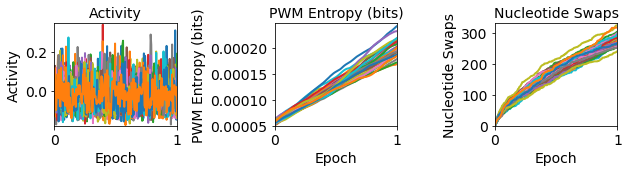

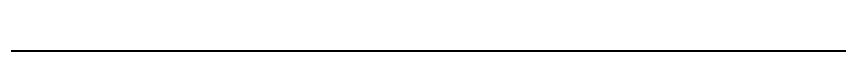

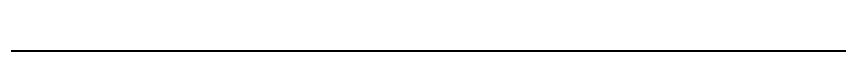

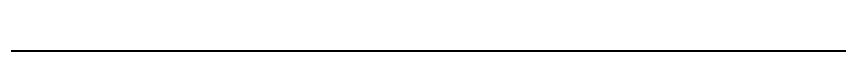

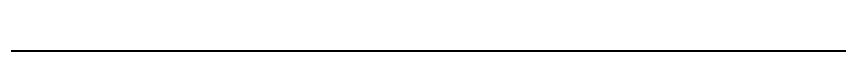

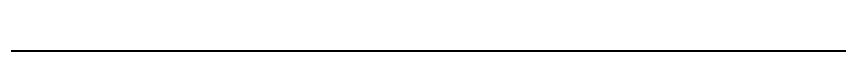

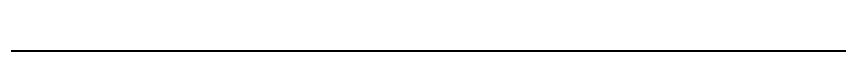

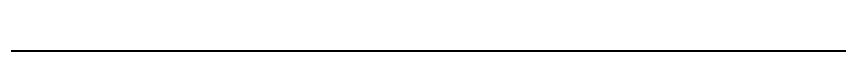

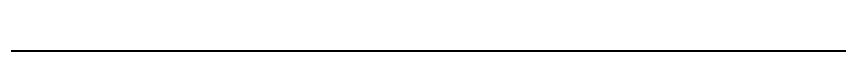

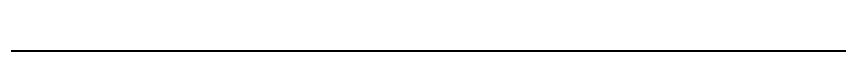

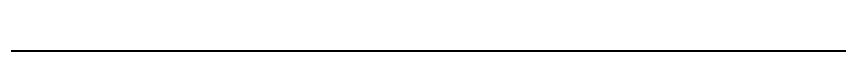

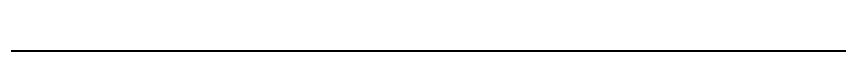

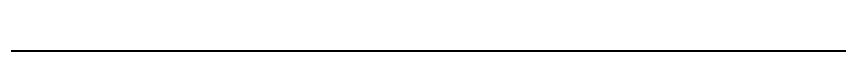

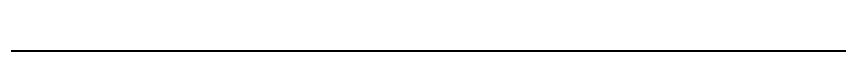

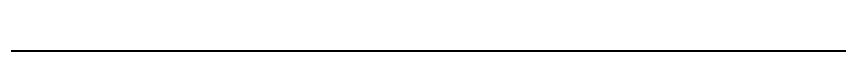

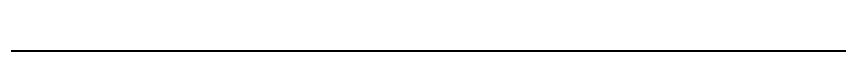

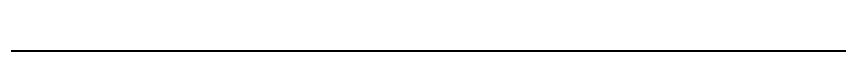

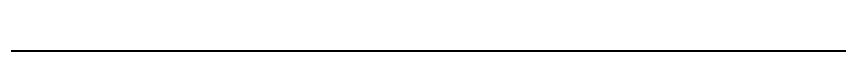

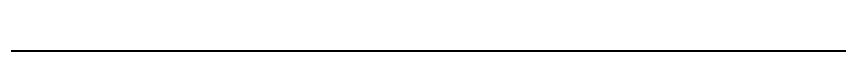

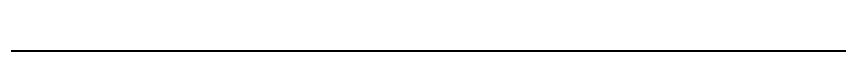

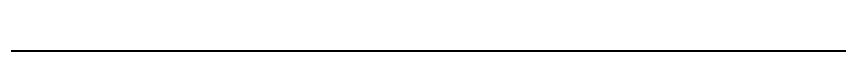

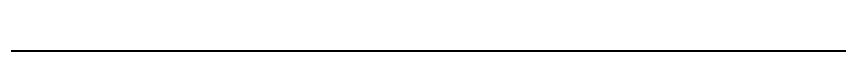

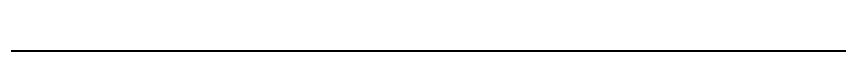

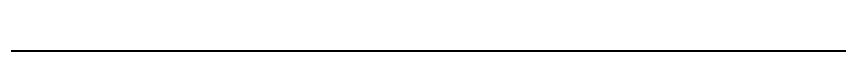

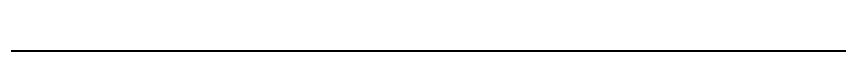

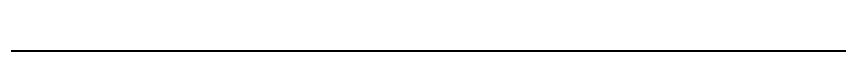

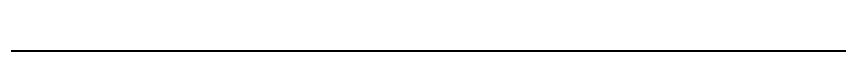

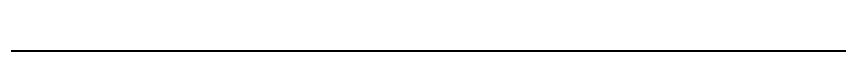

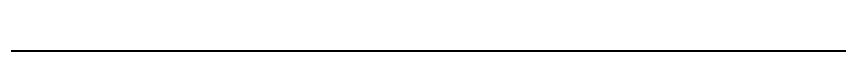

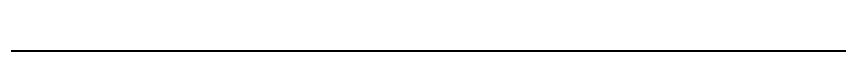

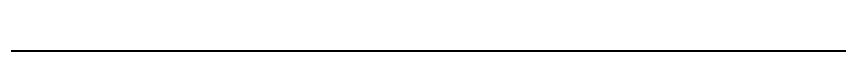

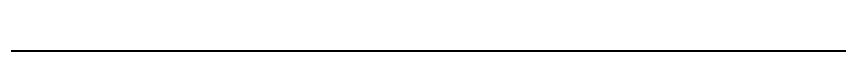

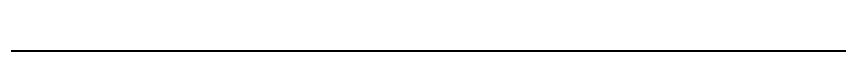

Experiment name = Gumbel-IN
Eval mode = gumbel
Normalize logits = True
Optimizing objective 0...
Epoch 1/1
200/200 [==============================] - 28s 140ms/step - loss: -3.3364


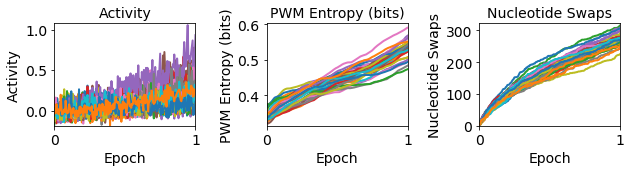

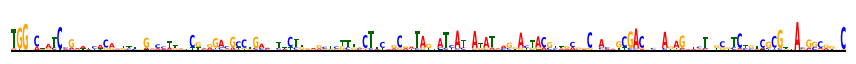

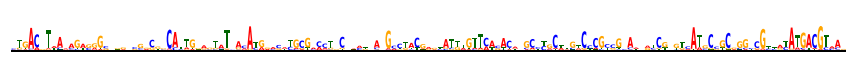

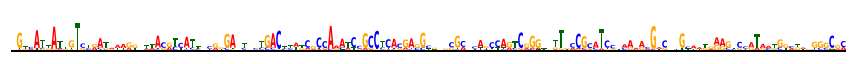

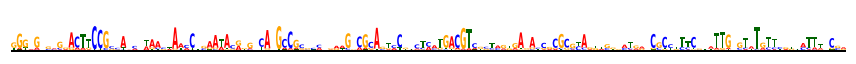

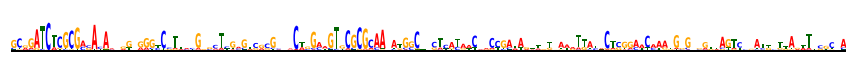

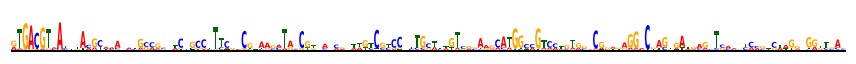

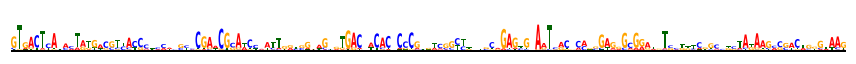

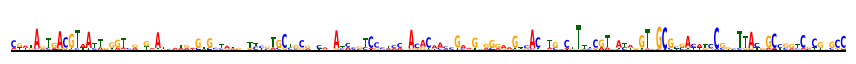

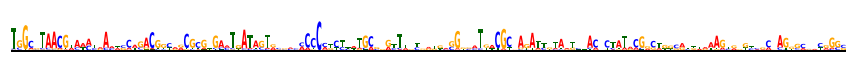

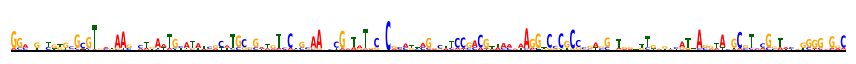

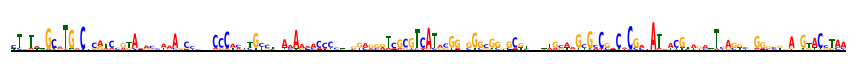

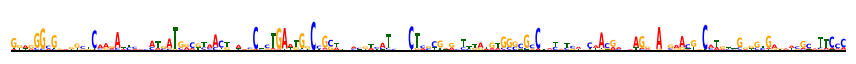

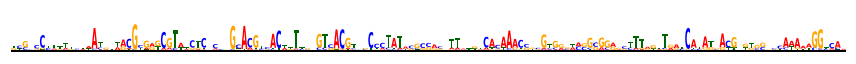

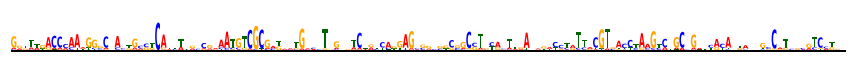

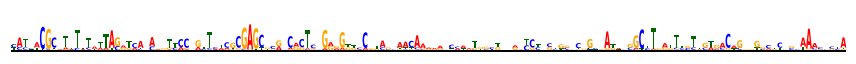

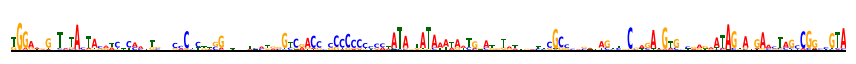

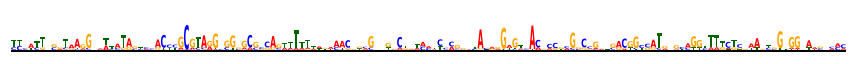

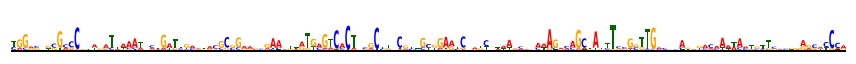

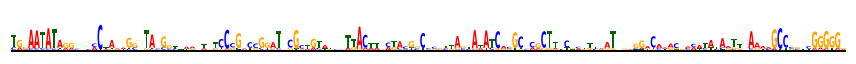

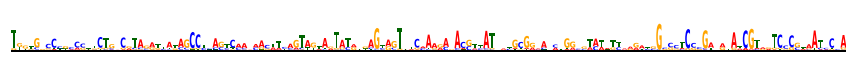

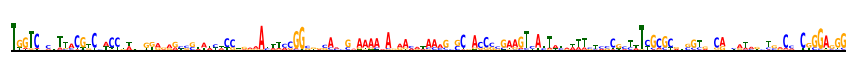

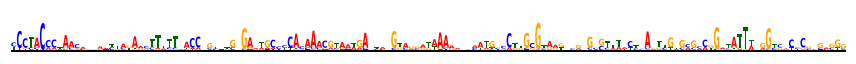

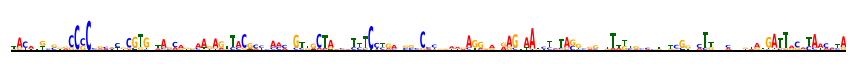

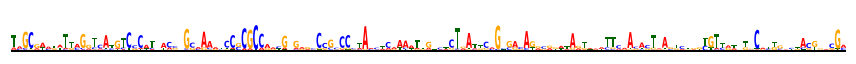

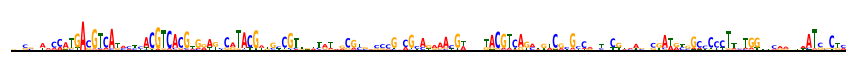

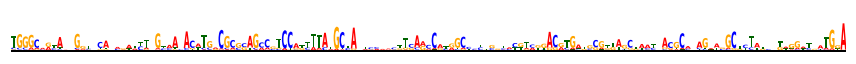

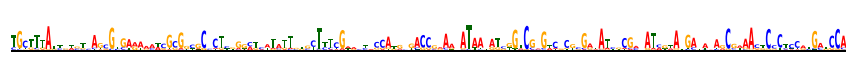

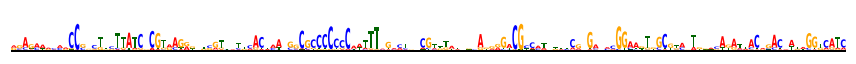

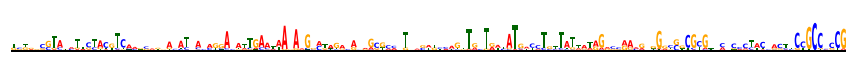

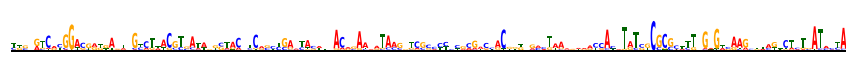

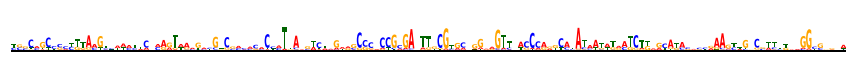

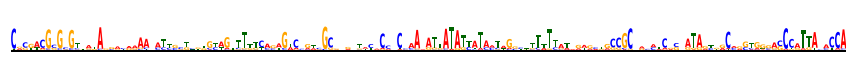

Experiment name = Evolved
Eval mode = evolve
Normalize logits = False
0
100
Experiment name = Sampled-IN
Eval mode = sample
Normalize logits = True
Optimizing objective 0...
Epoch 1/1
200/200 [==============================] - 28s 140ms/step - loss: -13.0664


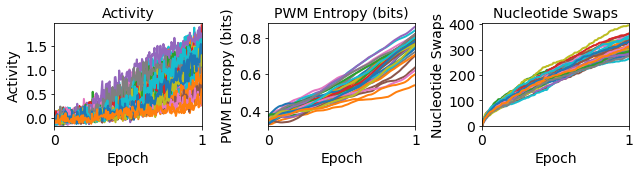

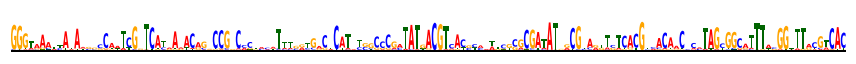

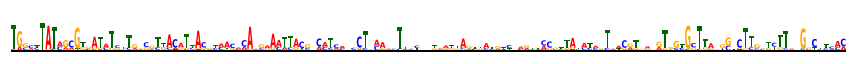

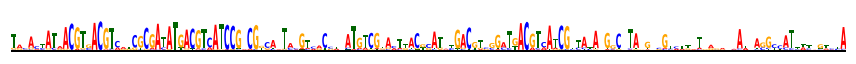

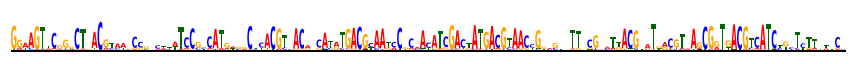

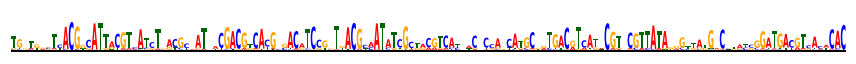

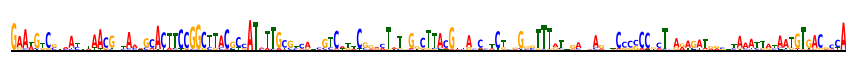

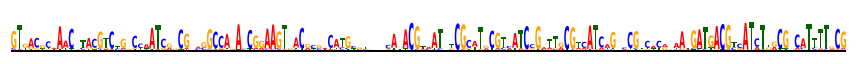

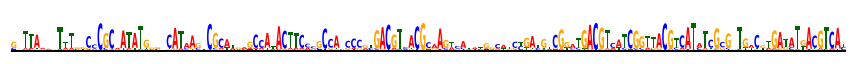

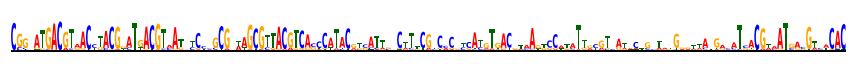

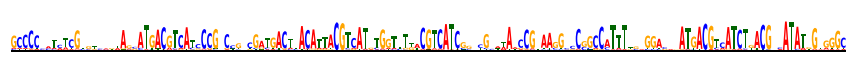

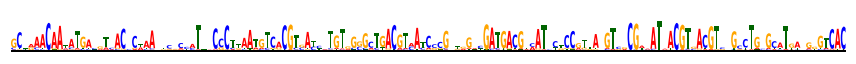

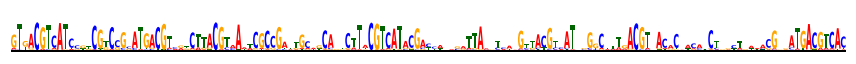

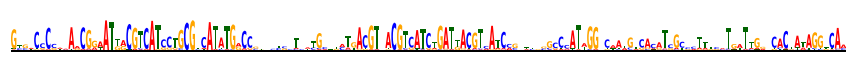

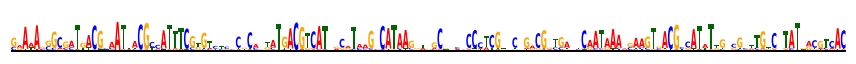

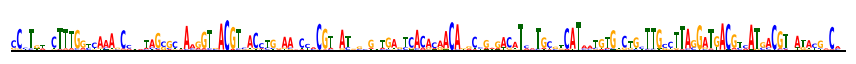

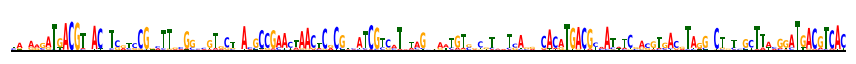

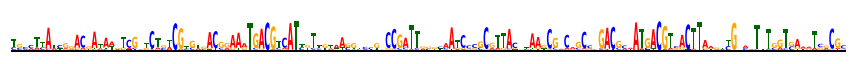

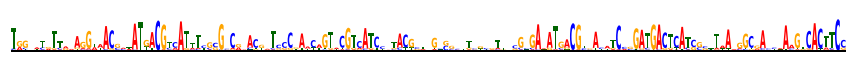

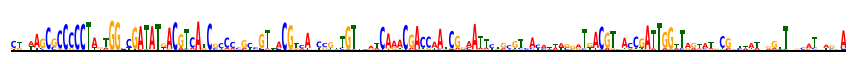

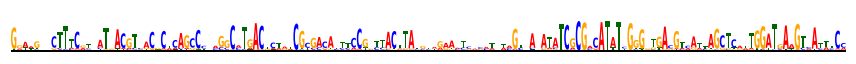

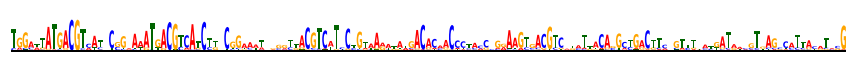

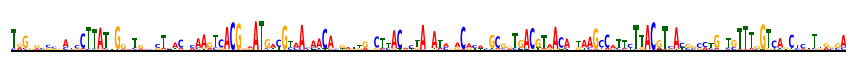

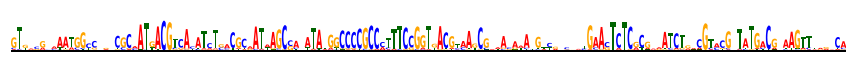

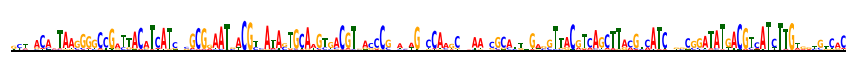

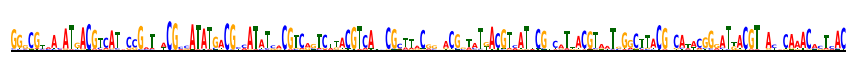

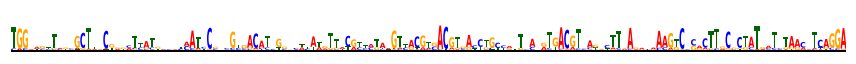

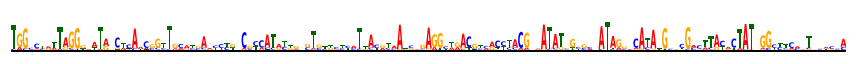

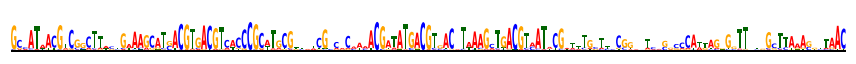

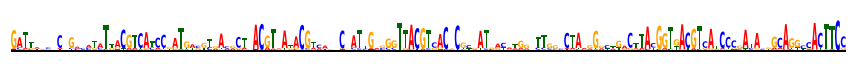

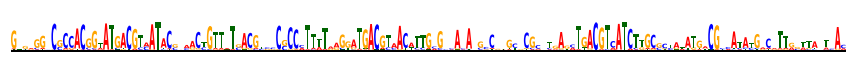

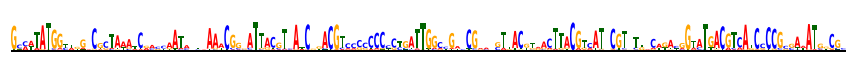

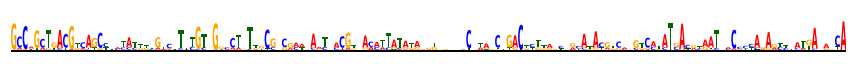

In [7]:
#Optimize max isoform proportions for the 'Alien1' (aka 'Simple') library

seq_template = 'N' * 145

rand_seed = 14755

#Run SeqProp Optimization

print("Running optimization experiment 'MPRA-DragoNN Activity Maximization'")

#Number of PWMs to generate per objective
n_sequences = 32
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1
#Number of steps (grad updates) per epoch
steps_per_epoch = 200
#Number of One-hot validation sequences to sample from the PWM
n_valid_samples = 10

experiment_name_list = ['Gumbel', 'Gumbel-IN', 'Evolved', 'Sampled-IN']
eval_mode_list = ['gumbel', 'gumbel', 'evolve', 'sample']
normalize_logits_list = [False, True, False, True]

result_dict = {
    'Gumbel' : {},
    'Gumbel-In' : {},
    'Evolved' : {},
    'Sampled-In' : {}
}

for experiment_name, eval_mode, normalize_logits in zip(experiment_name_list, eval_mode_list, normalize_logits_list) :
    
    print("Experiment name = " + str(experiment_name))
    print("Eval mode = " + str(eval_mode))
    print("Normalize logits = " + str(normalize_logits))

    K.clear_session()

    set_seed(rand_seed)
    
    target_output_ixs = [
        [5]
    ]

    sequence_templates = [
        seq_template
    ]

    losses, val_losses = zip(*[
        get_earthmover_loss(
            target_output_ixs[0],
            pwm_start=0,
            pwm_end=145,
            pwm_target_bits=1.8,
            pwm_entropy_weight=0.0
        )
    ])

    transforms = [
        None
    ]

    seqprop_predictors, valid_monitors, train_histories, valid_histories = run_seqprop(target_output_ixs, sequence_templates, losses, val_losses, transforms, n_sequences, n_samples, n_valid_samples, eval_mode, normalize_logits, n_epochs, steps_per_epoch)

    seqprop_predictor, valid_monitor, train_history, valid_history = seqprop_predictors[0], valid_monitors[0], train_histories[0], valid_histories[0]

    #Retrieve optimized PWMs and predicted cleavage distributionns
    consensus_seqs = []
    
    if seqprop_predictor is not None :
        _, optimized_pwm, _, _ = seqprop_predictor.predict(x=None, steps=1)
    
        for i in range(optimized_pwm.shape[0]) :
            consensus_seq = ''
            for j in range(optimized_pwm.shape[1]) :
                max_nt_ix = np.argmax(optimized_pwm[i, j, :, 0])
                if max_nt_ix == 0 :
                    consensus_seq += 'A'
                elif max_nt_ix == 1 :
                    consensus_seq += 'C'
                elif max_nt_ix == 2 :
                    consensus_seq += 'G'
                elif max_nt_ix == 3 :
                    consensus_seq += 'T'

            consensus_seqs.append(consensus_seq)

    result_dict[experiment_name] = {
        'seqprop_predictor' : seqprop_predictor,
        'valid_monitor' : valid_monitor,
        'train_history' : train_history,
        'valid_history' : valid_history,
        'consensus_seqs' : consensus_seqs
    }


--- Comparison of loss convergence ---


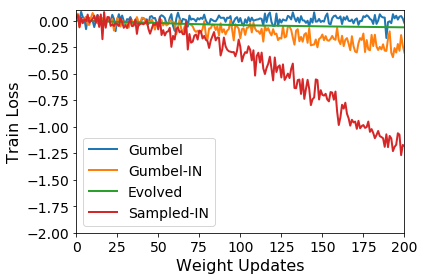

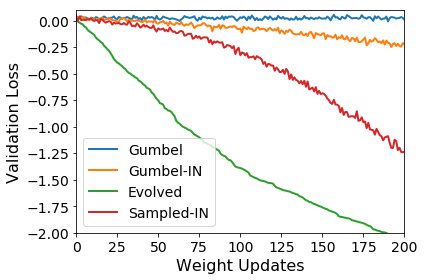

--- Comparison of mrl score convergence ---


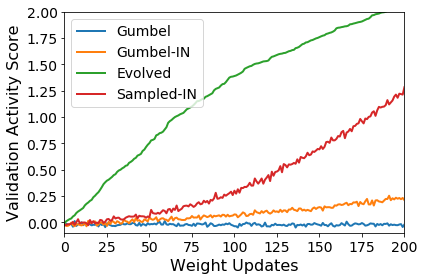

In [8]:

save_figs = True
fig_prefix = "eval_seqprop_mpradragonn_k562_sv40_earthmover_vs_evolution_and_gumbel_experiment_200_updates_many_sequences_"

print("--- Comparison of loss convergence ---")

for history_prefix in ['train', 'valid'] :

    loss_normalizer = n_sequences if history_prefix == 'train' else 1.
    y_label_prefix = 'Train' if history_prefix == 'train' else 'Validation'
    
    f = plt.figure(figsize=(6, 4))

    ls = []
    min_y_val = -2.0
    max_y_val = 0.1

    for experiment_ix, experiment_name in enumerate(experiment_name_list) :
        curr_history = result_dict[experiment_name][history_prefix + '_history']

        l1 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(curr_history.val_loss_history) / loss_normalizer, linewidth=2, linestyle='-', label=experiment_name)
        ls.append(l1[0])

        max_y_val = max(max_y_val, np.max(curr_history.val_loss_history) / loss_normalizer)

    plt.xlabel("Weight Updates", fontsize=16)
    plt.ylabel(y_label_prefix + " Loss", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlim(0, n_epochs * steps_per_epoch)
    plt.ylim(min_y_val, max_y_val)

    plt.legend(handles=ls, fontsize=14)
    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.png', transparent=True, dpi=150)
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.svg')
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.eps')

    plt.show()

print("--- Comparison of mrl score convergence ---")

f = plt.figure(figsize=(6, 4))

ls = []
min_y_val = -0.1
max_y_val = 2.0

for experiment_ix, experiment_name in enumerate(experiment_name_list) :
    curr_monitor = result_dict[experiment_name]['valid_monitor']
    meas_history = curr_monitor.measure_history
    meas_history = [np.mean(meas_history[k]) for k in range(len(meas_history))]

    l1 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(meas_history), linewidth=2, linestyle='-', label=experiment_name)
    ls.append(l1[0])

    #max_y_val = max(max_y_val, np.max(meas_history))

plt.xlabel("Weight Updates", fontsize=16)
plt.ylabel("Validation Activity Score", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0, n_epochs * steps_per_epoch)
plt.ylim(min_y_val, max_y_val)

plt.legend(handles=ls, fontsize=14)
plt.tight_layout()

if save_figs :
    plt.savefig(fig_prefix + '_valid_logodds_cmp.png', transparent=True, dpi=150)
    plt.savefig(fig_prefix + '_valid_logodds_cmp.svg')
    plt.savefig(fig_prefix + '_valid_logodds_cmp.eps')

plt.show()



Running optimization experiment 'MPRA-DragoNN Activity Maximization'
Experiment name = Gumbel
Eval mode = gumbel
Normalize logits = False
Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 263s 132ms/step - loss: 0.0498


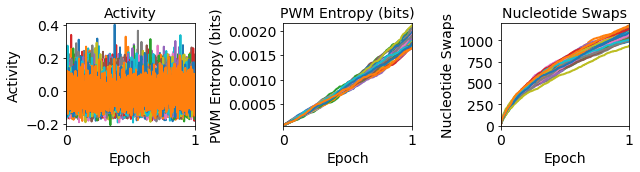

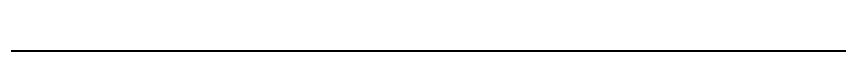

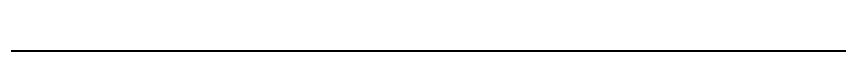

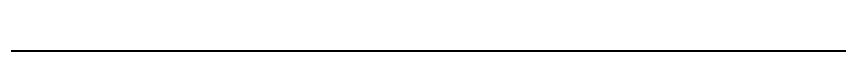

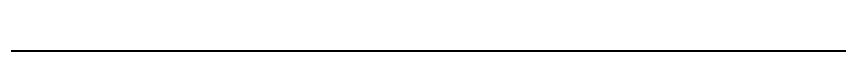

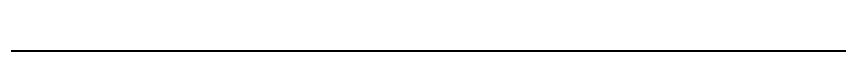

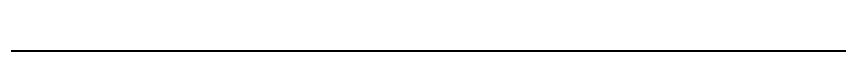

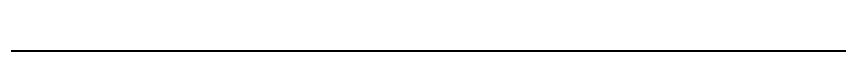

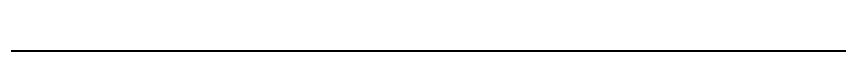

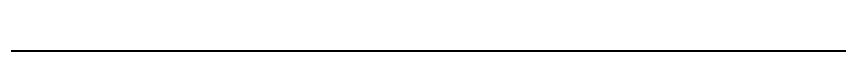

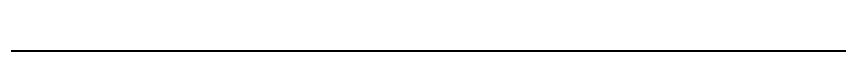

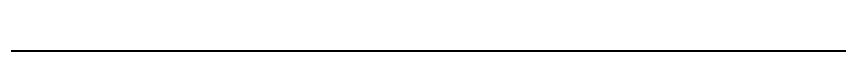

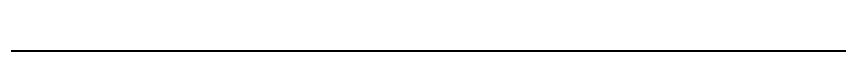

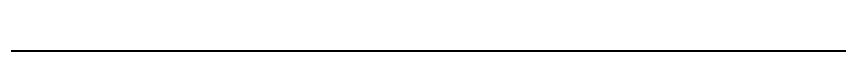

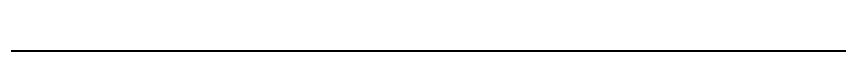

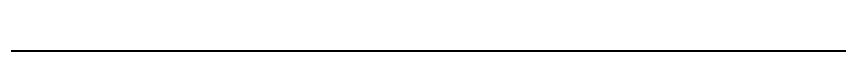

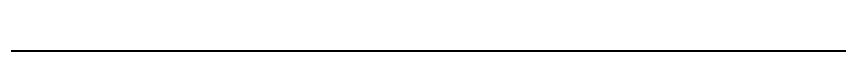

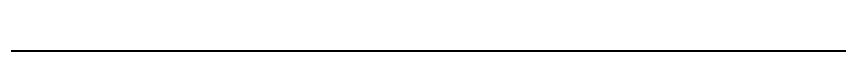

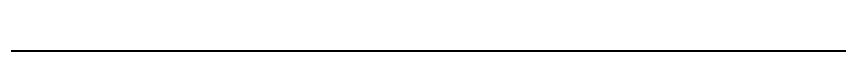

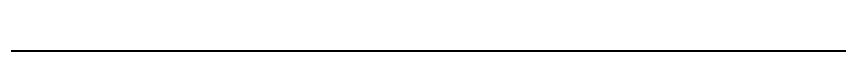

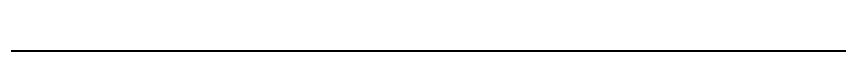

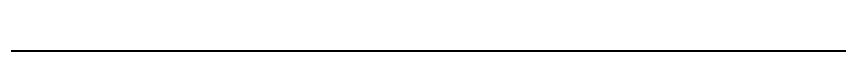

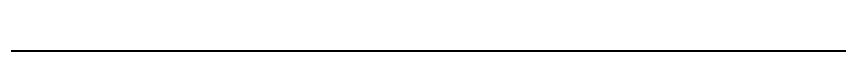

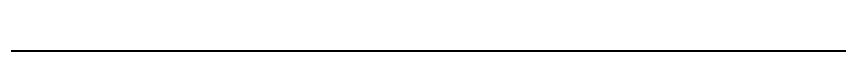

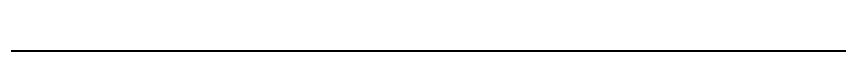

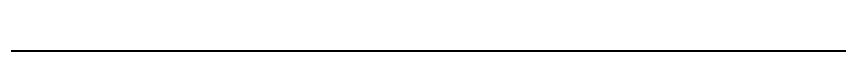

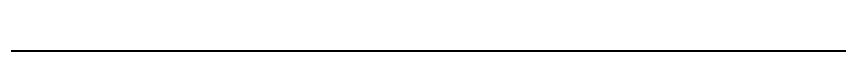

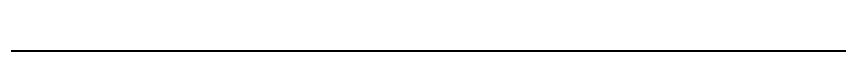

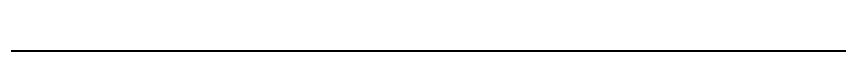

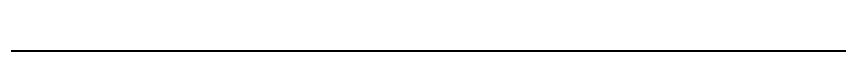

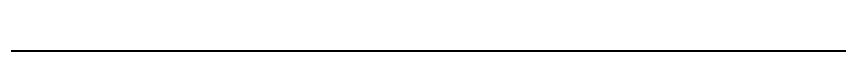

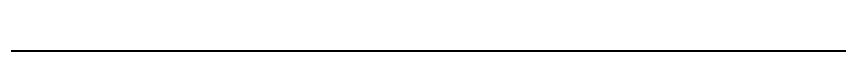

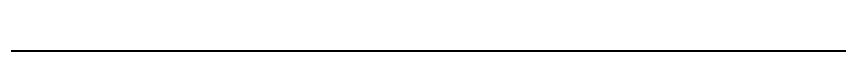

Experiment name = Gumbel-IN
Eval mode = gumbel
Normalize logits = True
Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 264s 132ms/step - loss: -90.1477


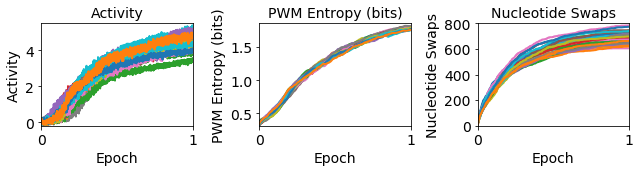

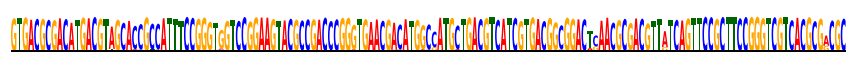

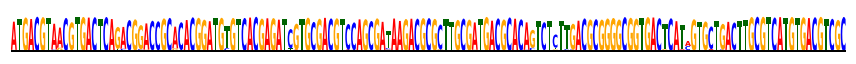

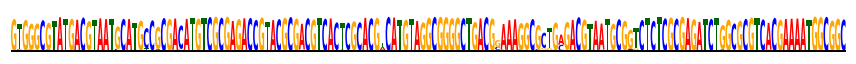

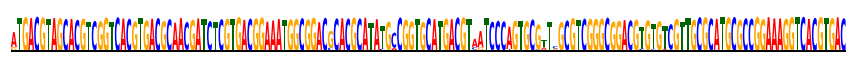

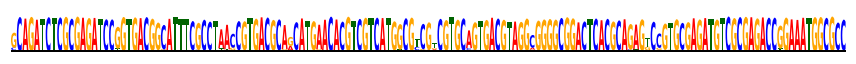

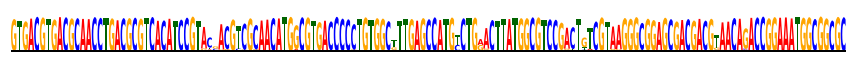

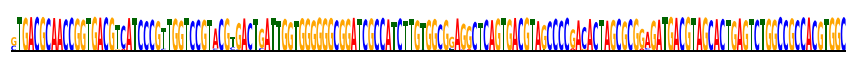

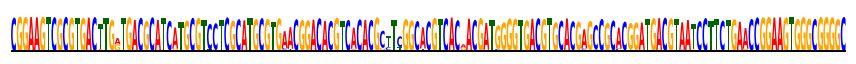

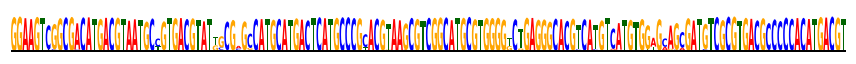

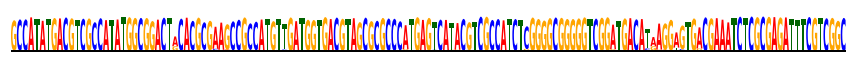

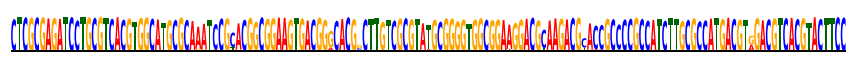

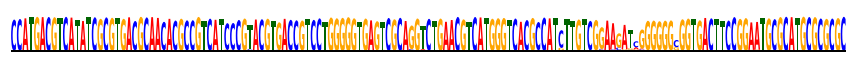

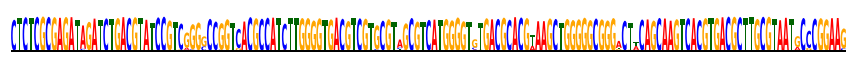

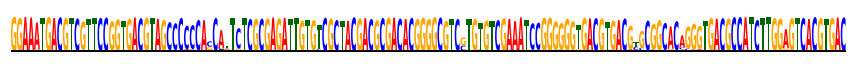

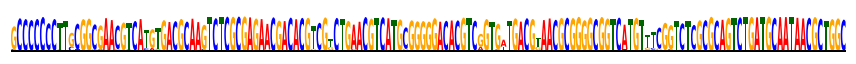

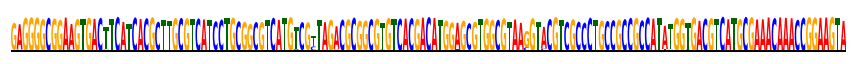

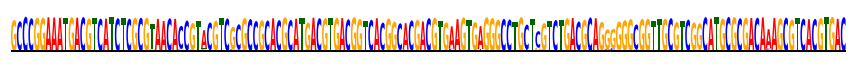

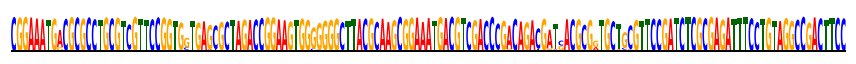

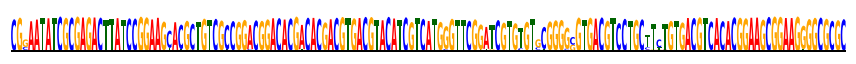

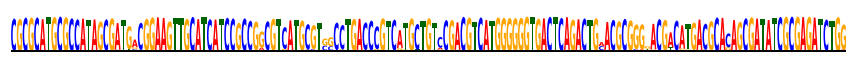

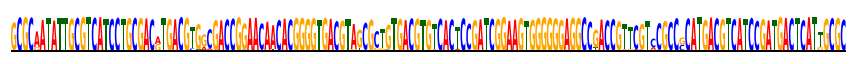

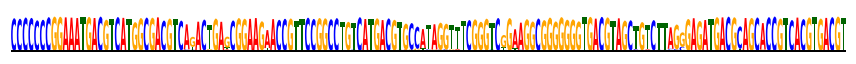

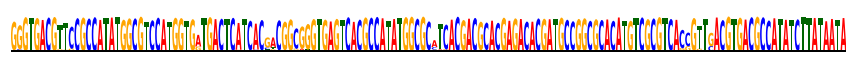

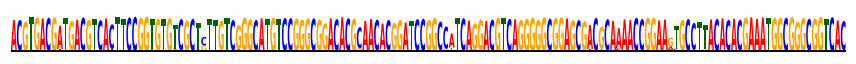

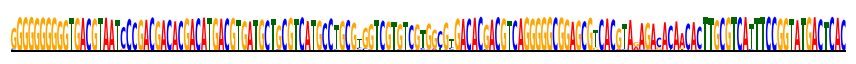

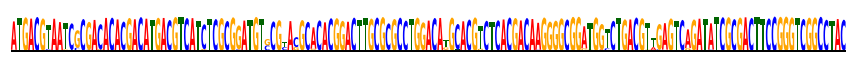

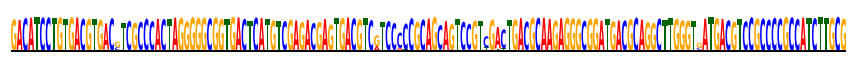

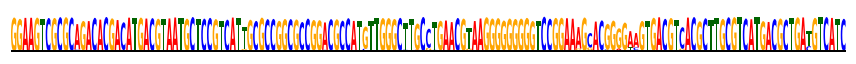

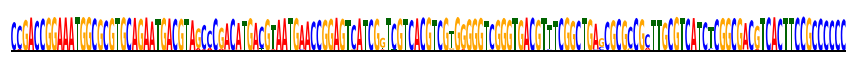

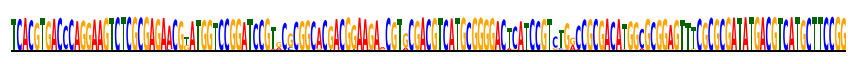

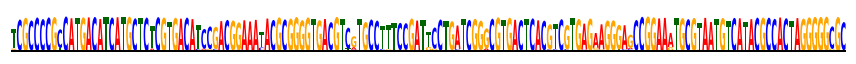

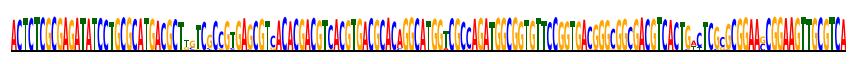

Experiment name = Evolved
Eval mode = evolve
Normalize logits = False
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
Experiment name = Sampled-IN
Eval mode = sample
Normalize logits = True
Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 266s 133ms/step - loss: -85.6884


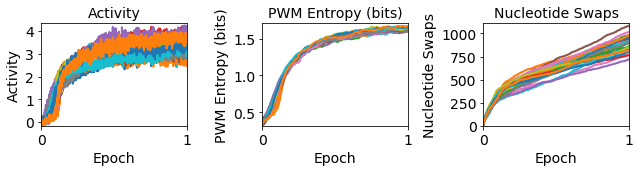

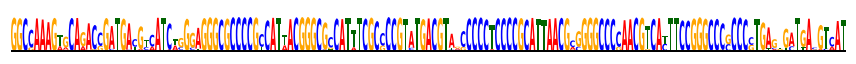

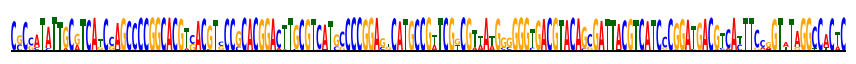

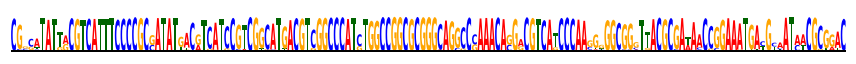

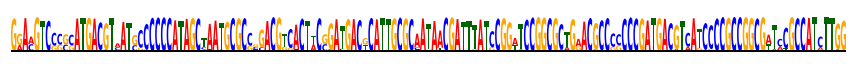

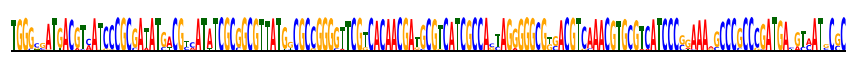

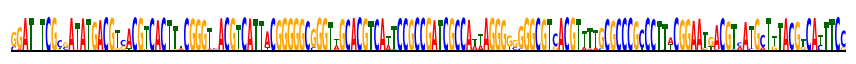

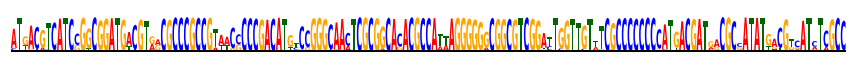

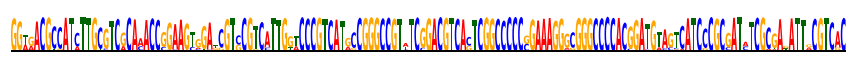

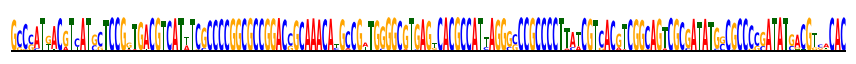

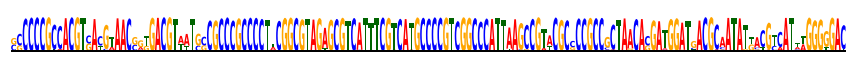

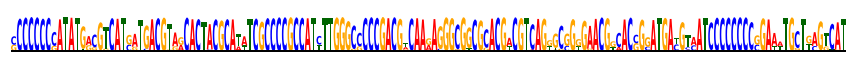

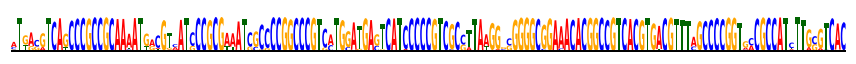

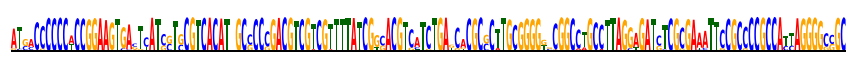

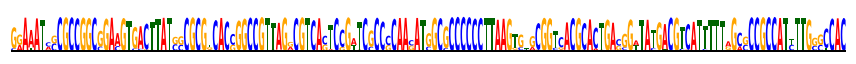

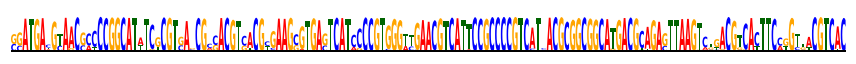

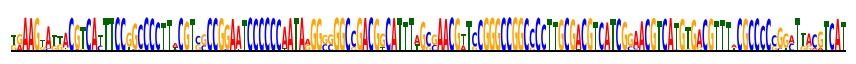

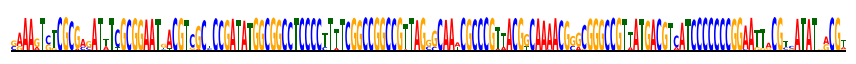

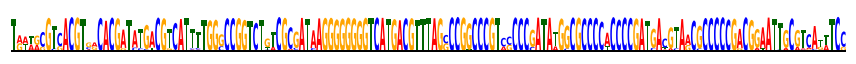

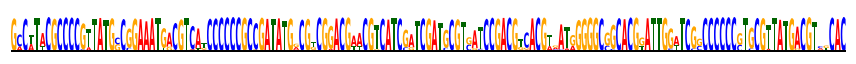

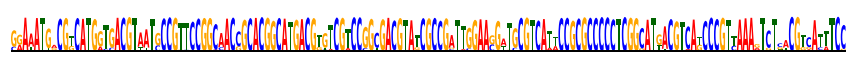

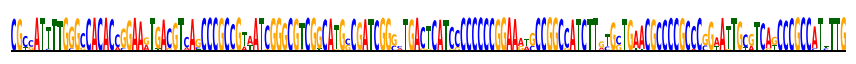

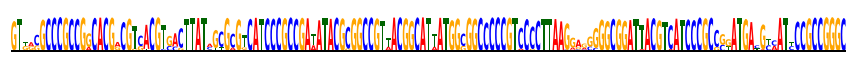

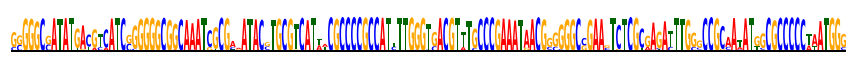

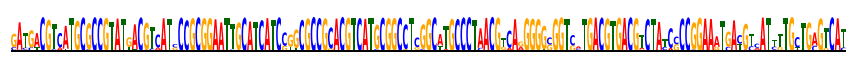

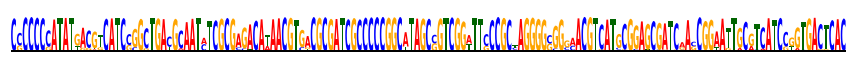

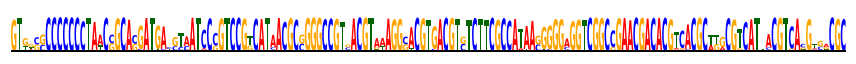

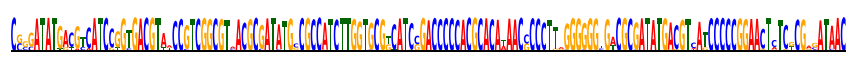

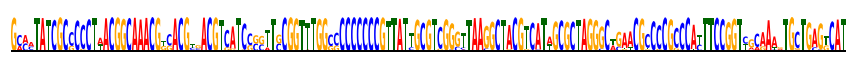

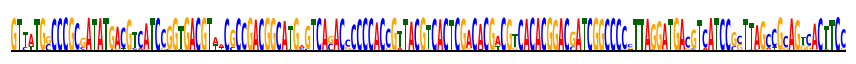

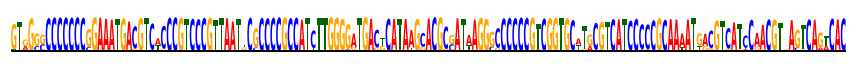

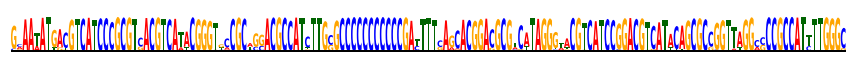

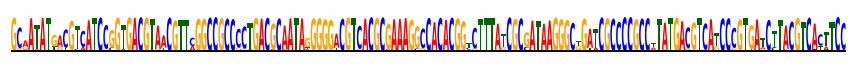

In [9]:
#Optimize max isoform proportions for the 'Alien1' (aka 'Simple') library

seq_template = 'N' * 145

rand_seed = 14755

#Run SeqProp Optimization

print("Running optimization experiment 'MPRA-DragoNN Activity Maximization'")

#Number of PWMs to generate per objective
n_sequences = 32
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1
#Number of steps (grad updates) per epoch
steps_per_epoch = 2000
#Number of One-hot validation sequences to sample from the PWM
n_valid_samples = 10

experiment_name_list = ['Gumbel', 'Gumbel-IN', 'Evolved', 'Sampled-IN']
eval_mode_list = ['gumbel', 'gumbel', 'evolve', 'sample']
normalize_logits_list = [False, True, False, True]

result_dict = {
    'Gumbel' : {},
    'Gumbel-In' : {},
    'Evolved' : {},
    'Sampled-In' : {}
}

for experiment_name, eval_mode, normalize_logits in zip(experiment_name_list, eval_mode_list, normalize_logits_list) :
    
    print("Experiment name = " + str(experiment_name))
    print("Eval mode = " + str(eval_mode))
    print("Normalize logits = " + str(normalize_logits))

    K.clear_session()

    set_seed(rand_seed)
    
    target_output_ixs = [
        [5]
    ]

    sequence_templates = [
        seq_template
    ]

    losses, val_losses = zip(*[
        get_earthmover_loss(
            target_output_ixs[0],
            pwm_start=0,
            pwm_end=145,
            pwm_target_bits=1.8,
            pwm_entropy_weight=0.0
        )
    ])

    transforms = [
        None
    ]

    seqprop_predictors, valid_monitors, train_histories, valid_histories = run_seqprop(target_output_ixs, sequence_templates, losses, val_losses, transforms, n_sequences, n_samples, n_valid_samples, eval_mode, normalize_logits, n_epochs, steps_per_epoch)

    seqprop_predictor, valid_monitor, train_history, valid_history = seqprop_predictors[0], valid_monitors[0], train_histories[0], valid_histories[0]

    #Retrieve optimized PWMs and predicted cleavage distributionns
    consensus_seqs = []
    
    if seqprop_predictor is not None :
        _, optimized_pwm, _, _ = seqprop_predictor.predict(x=None, steps=1)
    
        for i in range(optimized_pwm.shape[0]) :
            consensus_seq = ''
            for j in range(optimized_pwm.shape[1]) :
                max_nt_ix = np.argmax(optimized_pwm[i, j, :, 0])
                if max_nt_ix == 0 :
                    consensus_seq += 'A'
                elif max_nt_ix == 1 :
                    consensus_seq += 'C'
                elif max_nt_ix == 2 :
                    consensus_seq += 'G'
                elif max_nt_ix == 3 :
                    consensus_seq += 'T'

            consensus_seqs.append(consensus_seq)

    result_dict[experiment_name] = {
        'seqprop_predictor' : seqprop_predictor,
        'valid_monitor' : valid_monitor,
        'train_history' : train_history,
        'valid_history' : valid_history,
        'consensus_seqs' : consensus_seqs
    }


--- Comparison of loss convergence ---


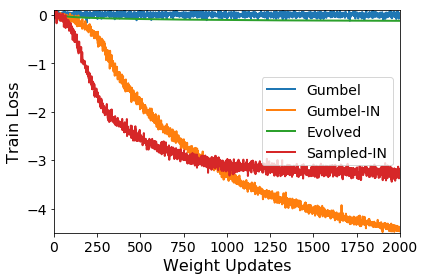

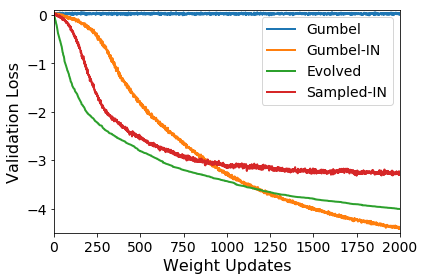

--- Comparison of mrl score convergence ---


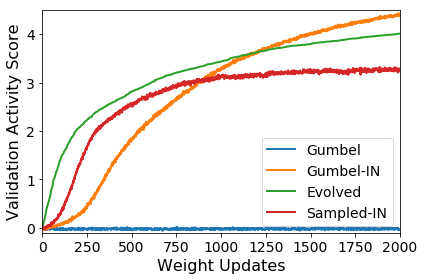

In [10]:

save_figs = True
fig_prefix = "eval_seqprop_mpradragonn_k562_sv40_earthmover_vs_evolution_and_gumbel_experiment_2000_updates_many_sequences_"

print("--- Comparison of loss convergence ---")

for history_prefix in ['train', 'valid'] :

    loss_normalizer = n_sequences if history_prefix == 'train' else 1.
    y_label_prefix = 'Train' if history_prefix == 'train' else 'Validation'
    
    f = plt.figure(figsize=(6, 4))

    ls = []
    min_y_val = -4.5
    max_y_val = 0.1

    for experiment_ix, experiment_name in enumerate(experiment_name_list) :
        curr_history = result_dict[experiment_name][history_prefix + '_history']

        l1 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(curr_history.val_loss_history) / loss_normalizer, linewidth=2, linestyle='-', label=experiment_name)
        ls.append(l1[0])

        max_y_val = max(max_y_val, np.max(curr_history.val_loss_history) / loss_normalizer)

    plt.xlabel("Weight Updates", fontsize=16)
    plt.ylabel(y_label_prefix + " Loss", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlim(0, n_epochs * steps_per_epoch)
    plt.ylim(min_y_val, max_y_val)

    plt.legend(handles=ls, fontsize=14)
    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.png', transparent=True, dpi=150)
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.svg')
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.eps')

    plt.show()

print("--- Comparison of mrl score convergence ---")

f = plt.figure(figsize=(6, 4))

ls = []
min_y_val = -0.1
max_y_val = 4.5

for experiment_ix, experiment_name in enumerate(experiment_name_list) :
    curr_monitor = result_dict[experiment_name]['valid_monitor']
    meas_history = curr_monitor.measure_history
    meas_history = [np.mean(meas_history[k]) for k in range(len(meas_history))]

    l1 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(meas_history), linewidth=2, linestyle='-', label=experiment_name)
    ls.append(l1[0])

    #max_y_val = max(max_y_val, np.max(meas_history))

plt.xlabel("Weight Updates", fontsize=16)
plt.ylabel("Validation Activity Score", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0, n_epochs * steps_per_epoch)
plt.ylim(min_y_val, max_y_val)

plt.legend(handles=ls, fontsize=14)
plt.tight_layout()

if save_figs :
    plt.savefig(fig_prefix + '_valid_logodds_cmp.png', transparent=True, dpi=150)
    plt.savefig(fig_prefix + '_valid_logodds_cmp.svg')
    plt.savefig(fig_prefix + '_valid_logodds_cmp.eps')

plt.show()

